### Reconstruction using a naive DCT compressive sensing approach

In [8]:
# %load simulate_cassi.py
# Simulate CASSI (Spatial-spectral or SS-CASSI, to be specific)
import numpy as np
import torch
from torch.autograd import Variable
from scipy.ndimage.interpolation import shift
import matplotlib.pyplot as plt

def generate_mask(inchannels, height, width):
    # Generate random binary mask
    mask = np.random.choice(2, size=(height, width+inchannels), p=(0.5, 0.5))
#     plt.imshow(mask)

    # Shear mask by different amounts for each channel
    middlechannel = int((inchannels - 1)/2)
    shifts = [ shift for shift in range(-middlechannel, middlechannel+1) ]

    # Apply mask to each channel (element-wise multiplication)
    maskblock = np.zeros((inchannels, height, width+inchannels), dtype=np.float32)
    for i, shift_val in enumerate(shifts):
    #     print(shift_val)
        # Shift mask along horizontal axis only
        # in (C, H, W) order (for pytorch later)
        maskblock[i,:,:] = shift(mask, (0, shift_val), mode='constant')
    middle = (width+inchannels+1)/2
    # print(middle)
    # print(range(int(middle-width/2),int(middle+width/2)))
    maskblock = maskblock[:, :, int(middle-width/2):int(middle+width/2)]
    # print(maskblocksquare.shape)
    # plt.imshow(maskblocksquare[25,:,:])
    maskblock = torch.Tensor(maskblock)
    maskblock = Variable(maskblock, requires_grad=False)
    maskblock = maskblock.unsqueeze(0) # Make 4d tensor
    # print(maskblock.shape)
    return maskblock
    
# Define image formation model
def image_formation(input_, maskblock):
    """Given an (1, inchannels, height, width) data block input_ and
    a torch tensor mask, compute the image that the camera sensor should see."""
    # Multiply elementwise by mask
#     print(type(maskblock))
#     print(type(input_))
#     print(maskblock.shape)
#     print(input_.shape)
    x = maskblock*input_
#     print(x.shape)
    # Sum along wavelength dimension to get a 2D image (1, height, width)
    return torch.sum(x, dim=1).unsqueeze(0) #Unsqueeze to make (1, 1, height, width)

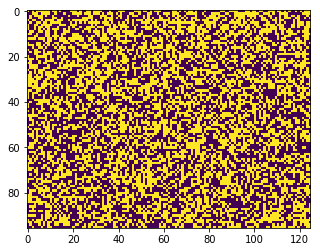

In [10]:
maskblock = generate_mask(29, 96, 96)

True